# Predict KBO 2022


## KBO 정규 리그 우승팀 및 포스트 시즌 진출 팀 예측

최근 12년간의 정규리그 성적을 바탕으로 2022 시즌 우승팀과 플레이오프 진출팀을 예측하는

머신러닝 모델을 만들어 보자.

### Import libraries


In [3]:
import pandas as pd
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

%matplotlib inline
mpl.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-colorblind')

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

### Data Set

분석 자료는 한국야구위원회 공식 홈페이지 기록실에서 추출한 팀기록을 사용하였다.  

링크 (https://www.koreabaseball.com/Record/Player/HitterBasic/Basic1.aspx)


In [5]:
# Read Data 
df = pd.read_csv('./data/kbo_data_2022.csv')

In [6]:
df.head(5)

,WIN,POST,YEAR,TEAM,AVG,G,PA,AB,R,H,...,PB,SB_A,CS_A,CS%,SBA,SB,CS,SB%,OOB,PKO.1
0,N,N,2010,넥센,0.262,133,5139,4452,570,1165,...,9,160,68,29.8,191,135,56,70.7,56,5
1,N,Y,2010,두산,0.281,133,5252,4538,731,1276,...,8,119,44,27.0,189,128,61,67.7,56,12
2,N,Y,2010,롯데,0.288,133,5261,4673,773,1345,...,6,131,62,32.1,175,124,51,70.9,62,7
3,N,Y,2010,삼성,0.272,133,5287,4436,681,1207,...,6,134,65,32.7,213,158,55,74.2,54,8
4,N,N,2010,한화,0.244,133,5009,4321,543,1053,...,7,151,58,27.8,191,121,70,63.4,56,11


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
YEAR,112.0,2015.776786,3.405639,2010.000,2013.00000,2016.0000,2019.000,2021.000
AVG,112.0,0.274509,0.015821,0.237,0.26175,0.2755,0.288,0.309
G,112.0,139.071429,6.570085,128.000,133.00000,144.0000,144.000,144.000
PA,112.0,5450.223214,298.276693,4866.000,5150.25000,5540.5000,5697.500,5870.000
AB,112.0,4759.687500,288.165025,4271.000,4436.75000,4878.0000,4995.250,5176.000
...,...,...,...,...,...,...,...,...
SB,112.0,107.598214,29.311763,47.000,88.00000,105.0000,121.750,204.000
CS,112.0,48.214286,11.938603,23.000,39.00000,47.0000,56.000,83.000
SB%,112.0,68.690179,5.151820,55.800,65.87500,69.2000,71.875,80.700
OOB,112.0,52.526786,7.904794,33.000,47.75000,53.0000,58.000,72.000


### Features (예측 변수)

시즌 중에도 예측 가능한 모델을 위해 안타수, 홈런수 등의 총 합계 데이터는 지양하고,  
비율로 구성된 값들만을 예측 변수로 사용해 초기 모델을 만들어 보자.

- AVG : batting AVeraGe (타율)
- OPS : On base Plus Slugging (출루율 + 장타율)
- RISP : batting AVG at Runner In Scoring Position (득점권타율)
- PH-BA : Pinch Hitter - Batting Average (대타 타율)
- ERA : Earned Runs Average (평균자책점)
- WHIP : Walks Plus Hits Divided by Innings Pitched (이닝당출루허용)
- FPCT : Fielding PerCenTage (수비율)

In [8]:
# features : AVG, OPS, RISP(Runner In Scoring Position) AVG, 
# PH-BA(Pinch Hitter - Batting Average), ERA, WHIP, FPCT(Fielding PerCenTage)
features = ['AVG', 'OPS', 'RISP', 'PH-BA', 'ERA', 'WHIP', 'FPCT']

In [9]:
list(df.loc[df['WIN'] == 1, features])

['AVG', 'OPS', 'RISP', 'PH-BA', 'ERA', 'WHIP', 'FPCT']

In [10]:
# Check the stats of Winners
win = df.loc[df['WIN'] == 'Y', features].mean()

In [11]:
win

AVG      0.286333
OPS      0.793750
RISP     0.294917
PH-BA    0.224917
ERA      4.112500
WHIP     1.376667
FPCT     0.984000
dtype: float64

In [12]:
post = df.loc[df['POST'] == 'Y', features].mean()

In [13]:
post

AVG      0.280455
OPS      0.781091
RISP     0.287909
PH-BA    0.232200
ERA      4.334727
WHIP     1.413091
FPCT     0.982727
dtype: float64

In [15]:
all = df.loc[:, features].mean()

In [16]:
all

AVG      0.274509
OPS      0.760875
RISP     0.279277
PH-BA    0.227634
ERA      4.658304
WHIP     1.465268
FPCT     0.981938
dtype: float64

In [17]:
feature_df = pd.DataFrame(zip(features,win,post,all), columns=['CATE','WIN', 'POST', 'ALL'])

In [19]:
feature_df

,CATE,WIN,POST,ALL
0,AVG,0.286333,0.280455,0.274509
1,OPS,0.793750,0.781091,0.760875
2,RISP,0.294917,0.287909,0.279277
3,PH-BA,0.224917,0.232200,0.227634
4,ERA,4.112500,4.334727,4.658304
5,WHIP,1.376667,1.413091,1.465268
6,FPCT,0.984000,0.982727,0.981938


In [22]:
# Korean Font for Chart Title
title_font = fm.FontProperties(fname='./Fonts/NanumGothicBold.ttf', size=20)

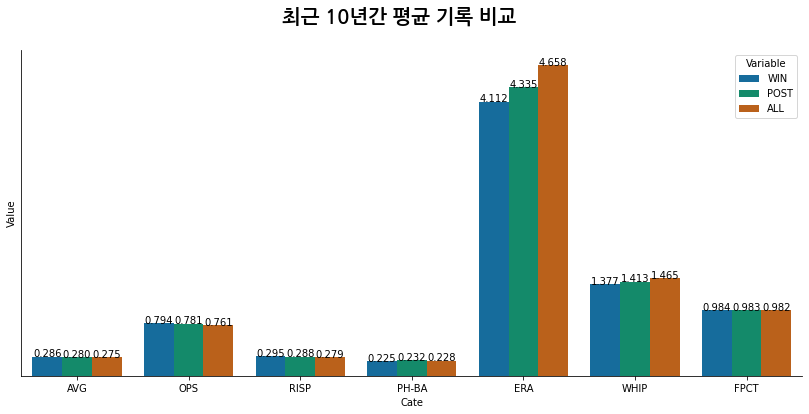

In [23]:
fig, ax = plt.subplots(figsize=(14, 6))
graph_df = feature_df.melt(id_vars='CATE').rename(columns=str.title)
sns.barplot(x='Cate', y='Value', hue='Variable', data=graph_df, ax=ax)
sns.despine(fig)

ax.grid(False)
ax.set_yticks([])

fig.suptitle('최근 10년간 평균 기록 비교', fontproperties=title_font)

for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    label = '{:.3f}'.format(y_value)
    plt.annotate(label, (x_value, y_value), ha='center', fontsize=10)
    
plt.show()

대타 성공률을 제외한 모든 지표가 우승팀 평균이 전체 평균보다 상당히 좋은 수준을 가지고 있으므로,   
우승팀 예측에 사용될 수 있음.

#### 데이터 정리와 타겟 변수 설정

In [25]:
# Cleaning Data for Classifier
# Change 'Y' to 1, 'N' to 0
df['WIN'] = df['WIN'].map(lambda x: 0 if x == 'N' else 1)
df['POST'] = df['POST'].map(lambda x: 0 if x == 'N' else 1)

In [26]:
# Set target data frames
win_y = df['WIN']
post_y = df['POST']

In [27]:
# Only pick the features with Ratio because it is middle of season
ratio_X = df[features]

In [28]:
ratio_X.head()

,AVG,OPS,RISP,PH-BA,ERA,WHIP,FPCT
0,0.262,0.714,0.268,0.221,4.55,1.50,0.982
1,0.281,0.805,0.284,0.210,4.62,1.38,0.982
2,0.288,0.813,0.315,0.202,4.82,1.43,0.981
3,0.272,0.774,0.265,0.247,3.94,1.36,0.982
4,0.244,0.690,0.263,0.172,5.43,1.57,0.984


In [29]:
# Split data set for train & test model
X_train, X_test, y_train, y_test = train_test_split(ratio_X, win_y, test_size=.2)

#### 로지스틱 회귀분석 모형을 사용해 초기 예측 모델 생성

분류 예측 모델 중 가장 기본이 되는 로지스틱 회귀분석 모형을 사용해,  
포스트시즌 진출 여부를 확인하는 예측 모델을 학습시켜보자

In [30]:
# Set pipeline with SS & Log_Regressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='lbfgs',
                                      random_state=27))
])

In [31]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression(random_state=27))])

#### 테스트 데이터를 통한 모델 정확도 확인

In [32]:
test_preds = pipeline.predict(X_test)

In [33]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.86      1.00      0.93        19
           1       1.00      0.25      0.40         4

    accuracy                           0.87        23
   macro avg       0.93      0.62      0.66        23
weighted avg       0.89      0.87      0.84        23



모델의 정확도는 87% 수준으로 비교적 정확한 편이라 할 수 있다.

#### 실제 데이터를 통한 확률 예측

In [38]:
# current stat of KBO leagues 
# AVG(타율), OPS('출루율'+'장타율'), RISP('득점권타율'), PH-BA('대타타율'), 
# ERA('평균자책점'), WHIP('이닝당출루허용'), FPCT('수비율')

stat_final = {
 'KIA': [0.272, 0.747, 0.273, 0.219, 4.2, 1.42, 0.98],
 '삼성': [0.27, 0.721, 0.281, 0.273, 4.29, 1.44, 0.978],
 'LG': [0.269, 0.742, 0.274, 0.236, 3.33, 1.27, 0.983],
 '롯데': [0.267, 0.711, 0.259, 0.268, 4.45, 1.46, 0.979],
 'NC': [0.257, 0.709, 0.265, 0.233, 3.9, 1.36, 0.976],
 '두산': [0.255, 0.689, 0.266, 0.246, 4.45, 1.48, 0.978],
 'SSG': [0.254, 0.732, 0.272, 0.228, 3.87, 1.29, 0.98],
 'KT': [0.254, 0.705, 0.239, 0.232, 3.51, 1.25, 0.982],
 '키움': [0.252, 0.697, 0.243, 0.182, 3.79, 1.34, 0.979],
 '한화': [0.245, 0.671, 0.237, 0.211, 4.83, 1.51, 0.975]
}

In [39]:
# Print probabilties for each team
predicts = {}
for team, value in stat_final.items():
    proba = pipeline.predict_proba([value])[0][1]*100
    predicts[team] = proba
    print(f'{team} :  {proba:.4}%')

KIA :  1.869%
삼성 :  0.3392%
LG :  25.86%
롯데 :  0.09988%
NC :  0.3407%
두산 :  0.04189%
SSG :  2.266%
KT :  1.946%
키움 :  0.5758%
한화 :  0.002464%


/Users/taeho/miniforge3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/taeho/miniforge3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/taeho/miniforge3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/taeho/miniforge3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/taeho/miniforge3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/taeho/miniforge3/lib/python3.9/site-packages/skl

In [40]:
def draw_bar_chart(predicts, title='KBO 정규시즌 우승확률'):
    # Draw chart with Seaborn
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.barplot(x=list(predicts.keys()), y=list(predicts.values()), ax=ax)
    sns.despine(fig)

    ax.grid(False)
    ax.set_yticks([])

    fig.suptitle(title, fontproperties=title_font)

    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        label = '{:.1f}%'.format(y_value)
        plt.annotate(label, (x_value, y_value), ha='center', fontsize=10)

    plt.show()

#### 우승 데이터는 케이스가 너무 적으므로 학습/테스트 데이터를 나누지 말고 전체 데이터로 학습을 시켜보자.

In [41]:
# Train model with whole dataset
pipeline.fit(ratio_X, win_y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression(random_state=27))])

In [42]:
# Print probabilties for each team
predicts = {}
for team, value in stat_final.items():
    proba = pipeline.predict_proba([value])[0][1]*100
    predicts[team] = proba
    print(f'{team} :  {proba:.4}%')

KIA :  2.419%
삼성 :  0.2939%
LG :  36.87%
롯데 :  0.0957%
NC :  0.3478%
두산 :  0.03627%
SSG :  2.315%
KT :  2.802%
키움 :  0.8399%
한화 :  0.001972%


/Users/taeho/miniforge3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/taeho/miniforge3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/taeho/miniforge3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/taeho/miniforge3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/taeho/miniforge3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/taeho/miniforge3/lib/python3.9/site-packages/skl

/Users/taeho/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49340 (\N{HANGUL SYLLABLE SAM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/taeho/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/taeho/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47215 (\N{HANGUL SYLLABLE ROS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/taeho/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/taeho/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46160 (\N{HANGUL SYLLABLE DU}) missing from current font.
  fig.canvas.print_fig

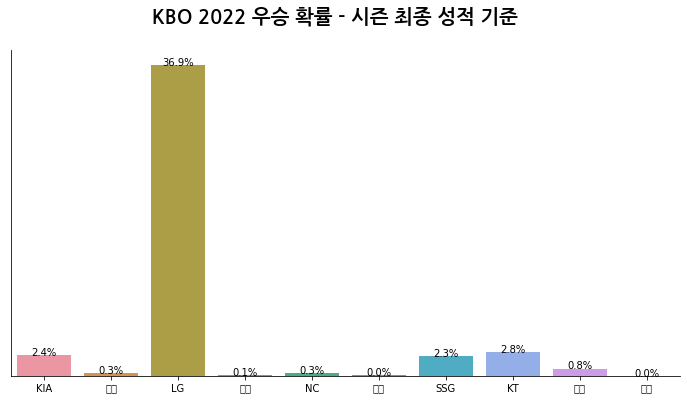

In [43]:
draw_bar_chart(predicts, 'KBO 2022 우승 확률 - 시즌 최종 성적 기준')

### 포스트 시즌 진출 확률 예측

우승보다는 통계적으로 조금 더 유의미한 값을 구할 수 있는 포스트 시즌 예측 확률을 구해보자.

KBO리그는 단일리그로 상위 5위까지 포스트 시즌에 진출 하는 형태로 운영되고 있어,  
최근 12년간 데이터 셋 내에 보다 많은 진출/실패의 경우가 존재하고 있기 때문에,  
우승 예측보다는 비교적 정확한 예측 모델 생성이 가능하다


In [44]:
# Train & Test data
X_train, X_test, y_train, y_test = train_test_split(ratio_X, post_y, test_size=.2)

In [45]:
# Set pipeline with SS & Log_Regressor
pp_post_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='lbfgs', 
                                      random_state=27))
])

In [46]:
# Train model
pp_post_lr.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression(random_state=27))])

In [47]:
# Predict and show model performance
test_preds = pp_post_lr.predict(X_test)

In [48]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.82      0.75      0.78        12
           1       0.75      0.82      0.78        11

    accuracy                           0.78        23
   macro avg       0.78      0.78      0.78        23
weighted avg       0.79      0.78      0.78        23



최근 10년간 포스트시즌 진출 여부 데이터를 80:20 비율로 나누어  
80%의 데이터로 학습시키고, 20% 데이터로 검증을 실시해 본 결과,   
약 78% 수준의 정확도를 가지는 예측 모델이 학습되었다.

In [49]:
# Show odds for playoff
predicts = {}
for team, value in stat_final.items():
    proba = pp_post_lr.predict_proba([value])[0][1]*100
    predicts[team] = proba
    print(f'{team} :  {proba:.4}%')

KIA :  62.58%
삼성 :  51.99%
LG :  98.95%
롯데 :  11.31%
NC :  47.02%
두산 :  6.231%
SSG :  86.01%
KT :  68.03%
키움 :  19.56%
한화 :  0.08991%


/Users/taeho/miniforge3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/taeho/miniforge3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/taeho/miniforge3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/taeho/miniforge3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/taeho/miniforge3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/taeho/miniforge3/lib/python3.9/site-packages/skl

/Users/taeho/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49340 (\N{HANGUL SYLLABLE SAM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/taeho/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/taeho/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47215 (\N{HANGUL SYLLABLE ROS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/taeho/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/taeho/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46160 (\N{HANGUL SYLLABLE DU}) missing from current font.
  fig.canvas.print_fig

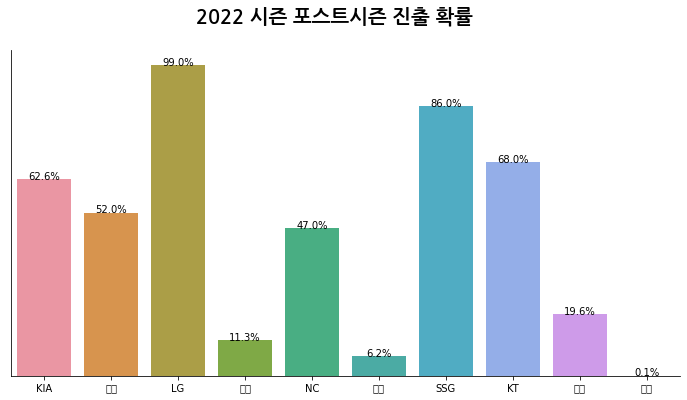

In [50]:
# 5/18 기준 포스트시즌 진출 확률
draw_bar_chart(predicts, title='2022 시즌 포스트시즌 진출 확률')

### Comment

SSG :  86.01%  
LG :  98.95%  
키움 :  19.56%  
KT :  68.03%  
KIA :  62.58%  
NC :  47.02%  
삼성 :  51.99%  
롯데 :  11.31%  
두산 :  6.231%  
한화 :  0.08991%  

2022년 시즌 결과 SSG, LG, 키움, KT, 기아가 포스트 시즌에 진출하였으나,  
현 예측 모델은 탈락한 삼성, NC의 확률이 더 높게 나타났다.  
이는 스트라이크존 정상화가 적용된 시즌으로 이전 시즌과는 다른 양상으로 진행된 것으로 판단된다.  
이를 설명하기 위해 다양한 변수를 활용한 상세한 분석을 진행해 볼 예정이다.  


